# Transformer Model

This tutorial will build a transformer model with a proper test-harness aroudn it.
The model will be trained on top of tiny shakespear dataset.

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
from sklearn.decomposition import PCA
import torch
from torch import nn
from torch.nn import functional as F
from torchviz import make_dot
from typing import List, Callable, Dict, Any, Union, Optional, Tuple, Generator
%matplotlib inline

/opt/homebrew/Caskroom/miniconda/base/envs/research/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Load Data**

First step is to load the data and explore it

In [4]:
torch_device = torch.device("mps" if torch.has_mps else ("cuda" if torch.cuda.is_available() else "cpu"))
print(f"Using device: {torch_device}")

# read the tiny shakespear dataset
with open('data/tiny_shakespeare.txt', 'r') as f:
    lines = f.read()

# read some stats
print(f"Number of characters: {len(lines)}")
chars = sorted(list(set(lines)))
print(f"Number of unique characters: {len(chars)}")
print(f"Characters: {chars}")

# build a dict
char2idx = {ch: i for i, ch in enumerate(chars)}
idx2char = {i: ch for i, ch in enumerate(chars)}
def encode_tensor(text: str) -> torch.Tensor:
    return torch.tensor([char2idx[ch] for ch in text])

def encode(text: str) -> List[int]:
    return [char2idx[ch] for ch in text]

def decode_tensor(encoded: torch.Tensor) -> str:
    # assert dim
    encoded = encoded.squeeze()
    if encoded.dim() == 2:
        encoded = encoded.argmax(dim=1)
    if encoded.dim() > 1:
        raise ValueError(f"Expected 1D or 2D tensor, got {encoded.dim()}D tensor")
    return ''.join([idx2char[idx] for idx in encoded.tolist()])

def decode(encoded: List[int]) -> str:
    return ''.join([idx2char[idx] for idx in encoded])

assert decode(encode("hello world")) == "hello world"
assert decode_tensor(encode_tensor("hello world")) == "hello world"
print(f"Res: {encode('hello world')}")

Using device: mps
Number of characters: 1115394
Number of unique characters: 65
Characters: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Res: [46, 43, 50, 50, 53, 1, 61, 53, 56, 50, 42]


## Detour: Different Encodings

Looking at a few different encoding libraries, in particular:

* bpe - low level open source encoder
* tokenizers - HuggingFaces implementation of tokenizers
* sentencepiece - Google's implementation of tokenizers
* tiktoken - OpenAIs production ready implementation of tokenizers

In [5]:
# do byte pair encoding
from bpe import Encoder as BPEncoder

bpe = BPEncoder(vocab_size=400)
bpe.fit([lines])
print(f"Vocabulary size: {bpe.bpe_vocab_size}")
print(bpe.tokenize('hello world hello'))

# try same with huggingface
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer

tok = Tokenizer(BPE())
trainer = BpeTrainer(vocab_size=100, special_tokens=["[UNK]", "[CLS]", "[SEP]", "[MASK]"])
tok.train(["data/tiny_shakespeare.txt"], trainer=trainer)
print(f"Vocabulary size: {tok.get_vocab_size()}")
print(tok.encode('hello world').tokens)
print(tok.encode('hello world').ids)

# use GPT2 tokenizer from tiktoken
import tiktoken
enc = tiktoken.get_encoding("gpt2")
# generates this automatically as a tensor
res = enc.encode("hello world")
print(f"Result: {res} - type: {type(res)}")

Vocabulary size: 80
['__sow', 'he', 'l', 'lo', '__eow', 'world', '__sow', 'he', 'l', 'lo', '__eow']



Vocabulary size: 100
['h', 'e', 'll', 'o ', 'w', 'or', 'l', 'd']
[50, 47, 88, 82, 65, 81, 54, 46]
Result: [31373, 995] - type: <class 'list'>


Next building the dataset, by encoding everything into a tensor of integers and splitting into train test.

In [6]:
# encode the tensor
data = encode_tensor(lines)

# split the data
split_idx = int(len(data) * 0.9)
train_data = data[:split_idx]
test_data = data[split_idx:]

print(f"Train data: {train_data.shape[0]:08}")
print(f"Test data:  {test_data.shape[0]:08}")

Train data: 01003854
Test data:  00111540


In [7]:
# define the blocksize (length of context)
batch_size = 4
block_size = 8

# build a batch generator - this should sample random section from the text
def random_batch(data: torch.Tensor, block_size: int, batch_size: int) -> Tuple[torch.Tensor, torch.Tensor]:
    '''Retrieves a random batch from the provided data'''
    # check the input data
    if data.dim() != 1:
        raise ValueError(f"Expected 1D tensor, got {data.dim()}D tensor")

    # create a random starting point
    # note: we need to have one last char for output
    # note: also need to have block_size difference
    start_idx = torch.randint(0, len(data) - block_size - 1, (batch_size,))

    # retrieve the content length (batchsi)
    content = torch.stack([data[i:i + block_size + 1] for i in start_idx])
    x = content[:, :-1]
    y = content[:, 1:]
    return x, y

def walk_batch(x: torch.Tensor, y: torch.Tensor) -> Generator[Tuple[torch.Tensor, torch.Tensor], None, None]:
    '''Walk the batch by creating a list of x, y pairs'''
    # perform a size check
    if x.shape != y.shape:
        raise ValueError(f"Expected x and y to have same shape, got {x.shape} and {y.shape}")
    if x.dim() != 2:
        raise ValueError(f"Expected x and y to be 2D, got {x.dim()}D and {y.dim()}D")
    
    # retrieve actual batch size and block size
    batch_size, block_size = x.shape

    # walk the batch
    for b in range(batch_size):
        for i in range(block_size):
            bx = x[b, :i+1]
            yield bx, y[b, i]

def padded_walk_batch(x: torch.Tensor, y: torch.Tensor, pad: int = 0) -> Tuple[torch.Tensor, torch.Tensor]:
    '''Pads elements to max block_size and '''
    # perform a size check
    if x.shape != y.shape:
        raise ValueError(f"Expected x and y to have same shape, got {x.shape} and {y.shape}")
    if x.dim() != 2:
        raise ValueError(f"Expected x and y to be 2D, got {x.dim()}D and {y.dim()}D")
    
    # retrieve actual batch size and block size
    _, block_size = x.shape

    _pad = lambda x: F.pad(x, (block_size - x.shape[-1], 0), mode="constant", value=pad) 
    res = [(_pad(tx), ty) for tx, ty in walk_batch(x, y)]
    return torch.stack([tpl[0] for tpl in res]).to(torch_device), torch.stack([tpl[1] for tpl in res]).to(torch_device)

print("--- Batch ---")
x, y = random_batch(train_data, block_size, batch_size)
print(f"X: {x.shape}")
print(f"Y: {y.shape}")
print(x)
print("--- Walk ---")
gen = walk_batch(x, y)
for wx, wy in gen:
    print(f"{wx} ({wx.shape}) -> {wy} ({wy.shape})")
print("--- Padded ---")
px, py = padded_walk_batch(x, y)
print(f"X: {px.shape}")
print(f"Y: {py.shape}")
print(px)

--- Batch ---
X: torch.Size([4, 8])
Y: torch.Size([4, 8])
tensor([[43, 57, 58,  1, 16, 47, 39, 52],
        [43, 11,  1, 50, 43, 58,  1, 51],
        [46, 58,  8,  0,  0, 30, 27, 25],
        [61, 53, 56, 51, 57,  8,  0, 35]])
--- Walk ---
tensor([43]) (torch.Size([1])) -> 57 (torch.Size([]))
tensor([43, 57]) (torch.Size([2])) -> 58 (torch.Size([]))
tensor([43, 57, 58]) (torch.Size([3])) -> 1 (torch.Size([]))
tensor([43, 57, 58,  1]) (torch.Size([4])) -> 16 (torch.Size([]))
tensor([43, 57, 58,  1, 16]) (torch.Size([5])) -> 47 (torch.Size([]))
tensor([43, 57, 58,  1, 16, 47]) (torch.Size([6])) -> 39 (torch.Size([]))
tensor([43, 57, 58,  1, 16, 47, 39]) (torch.Size([7])) -> 52 (torch.Size([]))
tensor([43, 57, 58,  1, 16, 47, 39, 52]) (torch.Size([8])) -> 1 (torch.Size([]))
tensor([43]) (torch.Size([1])) -> 11 (torch.Size([]))
tensor([43, 11]) (torch.Size([2])) -> 1 (torch.Size([]))
tensor([43, 11,  1]) (torch.Size([3])) -> 50 (torch.Size([]))
tensor([43, 11,  1, 50]) (torch.Size([4])) ->

In [8]:
# performance optimizations through tril
tr = torch.tril(torch.ones((4, 4), dtype=torch.float32))
print(tr)
ar = torch.arange(16, dtype=torch.float32).view(4, 4)
print(ar)
tr @ ar

tensor([[1., 0., 0., 0.],
        [1., 1., 0., 0.],
        [1., 1., 1., 0.],
        [1., 1., 1., 1.]])
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])


tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])

In [9]:
# creating a tensor for self-attention of size (BATCH, TIME, CHANNELS)
# Batch - number of data examples
# Time - Context length we can look at
# Channels - Number of features used
sample = torch.randn(4, 8, 2)
print(sample.shape)
print(sample[0])

# create an average up to the n-th time step (for a single example we could just use broadcasting on the batch dimension)
B, T, C = sample.shape
manual = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        # take the element from batch b and up to time t and mean it out
        manual[b, t] = sample[b, :t+1].mean(dim=0)
print(manual.shape)
print(manual[0])

# compute it but way more efficient
tril = torch.tril(torch.ones((T, T), dtype=torch.float32))
#print(tril)
tril = tril / torch.arange(1, T+1, dtype=torch.float32).view(T, 1)
#print(tril)
auto1 = tril @ sample
print(auto1.shape)
print(auto1[0])

print(f"Data is same: {torch.allclose(manual, auto1)}")

# can do the same with softmax
tril_mask = torch.tril(torch.ones((T, T), dtype=torch.float32))
tril2 = torch.zeros((T, T), dtype=torch.float32)
tril2 = tril2.masked_fill(tril_mask == 0, float('-inf'))
tril2 = F.softmax(tril2, dim=-1)
auto2 = tril2 @ sample
print(auto2.shape)
print(auto2[0])

print(f"Data is same: {torch.allclose(manual, auto2)}")

torch.Size([4, 8, 2])
tensor([[-0.2356,  1.1298],
        [-0.3788,  0.7653],
        [ 0.3301, -1.7384],
        [ 0.9123, -0.0854],
        [-0.8835, -1.3622],
        [ 0.7680, -0.1169],
        [ 0.5364,  1.9739],
        [-0.3348, -0.9146]])
torch.Size([4, 8, 2])
tensor([[-0.2356,  1.1298],
        [-0.3072,  0.9476],
        [-0.0948,  0.0522],
        [ 0.1570,  0.0178],
        [-0.0511, -0.2582],
        [ 0.0854, -0.2346],
        [ 0.1498,  0.0809],
        [ 0.0892, -0.0436]])
torch.Size([4, 8, 2])
tensor([[-0.2356,  1.1298],
        [-0.3072,  0.9476],
        [-0.0948,  0.0522],
        [ 0.1570,  0.0178],
        [-0.0511, -0.2582],
        [ 0.0854, -0.2346],
        [ 0.1498,  0.0809],
        [ 0.0892, -0.0436]])
Data is same: True
torch.Size([4, 8, 2])
tensor([[-0.2356,  1.1298],
        [-0.3072,  0.9476],
        [-0.0948,  0.0522],
        [ 0.1570,  0.0178],
        [-0.0511, -0.2582],
        [ 0.0854, -0.2346],
        [ 0.1498,  0.0809],
        [ 0.0892, -0.0

Note that this will not give us a full training batch to work with

**BiGram Language Model**

This model has a content length of just one, so it can only predict the next char based on the previous one.
This is done through an embedding matrix.

In [10]:
([0] * block_size + [1, 2, 3])[-block_size:]

[0, 0, 0, 0, 0, 1, 2, 3]

In [11]:
class LModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.vocab_size = vocab_size

    @property
    def device(self):
        return next(self.parameters()).device
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

    def generate(self, max_len: int = 100) -> List[int]:
        """Generates a language output from the model"""
        # set model to eval mode
        self.eval()

        # setup output
        out = []
        for i in range(max_len):
            # setup tensor for generation
            prev = torch.tensor((([0] * block_size) + out)[-block_size:], device=self.device, dtype=torch.long).view(1, -1)
            # compute logits
            logits = self.forward(prev)
            # get the last logits and convert to prob
            logits = logits[:, -1]
            probs = F.softmax(logits, dim=-1)
            # sample from the distribution
            sample = torch.multinomial(probs, 1)
            # append to output
            out.append(sample.detach().cpu().item())
        
        return out
    
    def generate_str(self, max_len: int = 100) -> str:
        """Generates a language output from the model"""
        return "".join([idx2char[idx] for idx in self.generate(max_len=max_len)])

class BigramLM(LModel):
    def __init__(self, vocab_size, emb_size=128):
        super().__init__(vocab_size)

        # define the embedding layer
        self.embedding = nn.Embedding(vocab_size, emb_size) # (vocab_size, emb_size)
        self.pos_embedding = nn.Embedding(block_size, emb_size) # (block_size, emb_size)
        self.lm_head = nn.Linear(emb_size, vocab_size) # (emb_size, vocab_size)
    
    def forward(self, x):
        # validate device
        if self.device != x.device:
            x = x.to(self.device)

        # get ids
        B, T = x.shape

        # retrieve the embeddings
        chars = self.embedding(x) # (B, block_size, emb_size)
        pos = self.pos_embedding(torch.arange(T, device=x.device))  # (block_size, emb_size) - will be broadcases to (B, block_size, emb_size)
        # add embeddings
        embs = chars + pos # (B, block_size, emb_size)

        # compute logits (push it to vocab_size)
        # NOTE: we treat each B*block_size element as an independent example for which we predict the output
        logits = self.lm_head(embs) # (B, block_size, vocab_size)
        return logits
    
    def loss(self, x, y):
        # validate device
        if self.device != y.device:
            y = y.to(self.device)

        # compute the logits
        logits = self.forward(x)  # (B, block_size, vocab_size)

        # requires a reshape from (B, T, vocab_size) to (B*block_size, vocab_size)
        logits = logits.view(-1, self.vocab_size)
        target = y.reshape(-1) # (B*block_size)

        # compute the loss
        loss = F.cross_entropy(logits, target) # (B*block_size, vocab_size), (B*block_size)
        return loss

# create model and test
#dev = "cpu"
dev = torch_device
vocab_size = len(chars)
model = BigramLM(vocab_size)
model.to(dev)
x, y = random_batch(train_data, block_size, batch_size)
#bx, by = random_batch(x, y)
loss = model.loss(x.to(dev), y.to(dev))
print(f"Loss: {loss}")
print(f"Generated: {model.generate_str()}")
print(f"Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


Loss: 4.215925216674805
Generated: iyYb!dN-a;aaagKl'qU-W,DHbvuoH;gQZrmh'vTHSPoZskBQ:?N$jQVIHwHCVXqSESEHUHRHSik.DK,jxwgbqPPob,wTeoIHanbR
Params: 17729


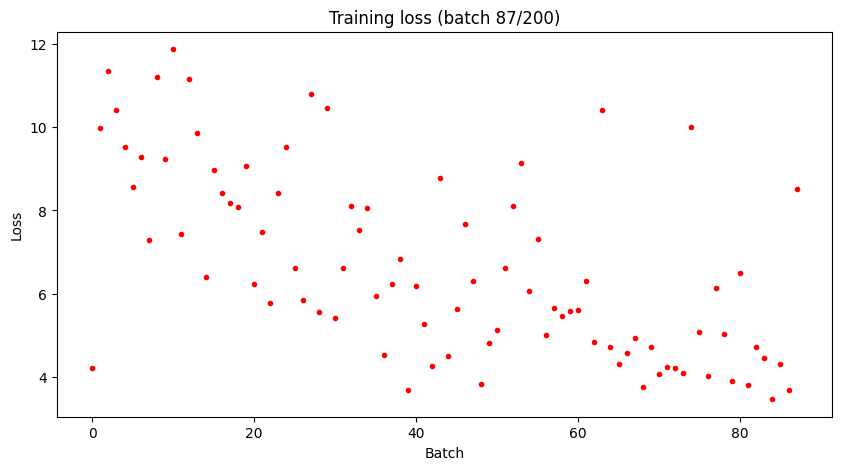

In [12]:

# create interactive loss plot
from IPython.display import clear_output

def train_model(model, lr, batches=400, block_size: int = 8, batch_size: int = 4):
    # set model to train mode
    model.train()

    # create the plot
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.set_xlabel("Batch")
    ax.set_ylabel("Loss")
    ax.set_title("Training loss")

    # train the model
    optim = torch.optim.Adam(model.parameters(), lr=lr)
    for epoch in range(batches):
        bx, by = random_batch(train_data, block_size, batch_size)
        loss = model.loss(bx, by)
        loss.backward()
        optim.step()
        optim.zero_grad()

        # plot the loss as a line
        ax.set_title(f"Training loss (batch {epoch}/{batches})")
        ax.plot(epoch, loss.item(), "r.")
        clear_output(wait=True)
        display(fig)

    # generate test loss
    tx, ty = random_batch(test_data, block_size, 100)
    test_loss = model.loss(tx, ty)
    print(f"Test Loss: {test_loss}")

train_model(model, .1, batches=200)
for i in range(10):
    print(f"--- GENERATING {i} ---")
    print(model.generate_str())


**Self Attention**

We want to define a self attention head step by step:

In [ ]:
channels = 32
head_size = 16

# define the input
x = torch.randn(batch_size, block_size, channels)  # (B, T, C)

# define the key and query vectors
k = nn.Linear(channels, head_size)  # (C, H) - Weigths
q = nn.Linear(channels, head_size)  # (C, H) - Weights
v = nn.Linear(channels, head_size)  # (C, H) - Weights

# generate the embedding vectors
xk = k(x)   # (B, T, H)
xq = q(x)   # (B, T, H)

# compute score manually
# NOTE: score should generate a vector of shape (T) for each batch element (so (B, T))
mscore = torch.zeros((batch_size, block_size, block_size), dtype=torch.float32)
for b in range(batch_size):
    for t in range(block_size):
        # compute the score for the current time step
        for r in range(t+1):
            mscore[b, t, r] = xq[b, t, :].dot(xk[b, r, :])
print(mscore.shape)

print(f"score q: {xq.shape}")
print(f"score tp: {xk.transpose(-1, -2).shape}")
wei = xq @ xk.transpose(-1, -2)  # (B, T, T) - Multiply along the embedding dimension (B, T, H) @ (B, H, T) -> (B, T, T)

# apply tril mask
tril = torch.tril(torch.ones((block_size, block_size), dtype=torch.float32))
score = wei.masked_fill(tril == 0, 0)
wei = wei.masked_fill(tril == 0, float('-inf'))
# divide by key data length (used for more stable gradients)
# NOTE: this will stabilize gradients of softmax
wei = wei / head_size**-.5 #np.sqrt(head_size)
wei = F.softmax(wei, dim=-1)

xv = v(x)  # (B, T, H)
out = wei @ xv
#score = (xq * xk).sum(-1)  # (B, T)
#print(score.shape)

print(f"Diff is: {torch.allclose(mscore, score)} | {(mscore - score).abs().sum()}")
#assert torch.allclose(mscore, score)

print("-- Out --")
print(out.shape)

torch.Size([4, 8, 8])
score q: torch.Size([4, 8, 16])
score tp: torch.Size([4, 16, 8])
Diff is: True | 1.023709774017334e-05
-- Out --
torch.Size([4, 8, 16])


In [ ]:
# test softmax variance and peakyness
x = torch.randn(10)
print(x)
print(F.softmax(x, dim=-1))
print(F.softmax(x*8, dim=-1))

# Notice that this pushes more weight into the highest element (since the math behind softmax is exponential)

tensor([-1.3193, -0.6377, -1.0888, -0.1635, -1.9530, -2.2560, -0.7793,  0.2158,
         0.2549, -2.4271])
tensor([0.0504, 0.0996, 0.0634, 0.1600, 0.0267, 0.0197, 0.0864, 0.2338, 0.2432,
        0.0166])
tensor([1.9200e-06, 4.4802e-04, 1.2133e-05, 1.9902e-02, 1.2069e-08, 1.0687e-09,
        1.4436e-04, 4.1366e-01, 5.6583e-01, 2.7184e-10])


In [ ]:
# create an attention head module
class AttentionHead(nn.Module):
    def __init__(self, emb_size: int, head_size: int, encoder: bool, block_size: int = 32, dropout: float = None):
        super().__init__()
        self.emb_size = emb_size
        self.head_size = head_size
        self.encoder = encoder

        # define the key, query, and value vectors
        self.k = nn.Linear(emb_size, head_size)
        self.q = nn.Linear(emb_size, head_size)
        self.v = nn.Linear(emb_size, head_size)

        # check for dropout
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)

        # create register buffer for the tril
        self.register_buffer("tril", torch.tril(torch.ones((block_size, block_size), dtype=torch.float32)))
    
    def forward(self, x):
        # compute key and query vectors
        xk = self.k(x)  # (B, T, H)
        xq = self.q(x)  # (B, T, H)

        # compute weight by transpose and matmul product
        wei = xq @ xk.transpose(-1, -2)

        # apply tril mask
        if self.encoder:
            wei = wei.masked_fill(self.tril == 0, float('-inf'))
        
        # normalize weights and check for dropout
        wei = F.softmax(wei / self.head_size**-.5, dim=-1)
        if hasattr(self, "dropout"):
            wei = self.dropout(wei)

        # normalize data and apply softmax
        xv = self.v(x)  # (B, T, H)
        out = wei @ xv

        return out


class MultiAttentionHead(nn.Module):
    def __init__(self, num_heads: int, emb_size: int, head_size: int, block_size: int, encoders: bool, dropout: float = None) -> None:
        super().__init__()

        self.heads = nn.ModuleList([AttentionHead(emb_size, head_size, block_size=block_size, encoder=encoders, dropout=dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, emb_size)
        if dropout is not None:
            self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        # compute the attention for each head
        outs = [head(x) for head in self.heads]

        # concatenate the outputs
        out = torch.cat(outs, dim=-1)

        # project back to the original embedding size
        out = self.proj(out)

        # apply dropout
        if hasattr(self, "dropout"):
            out = self.dropout(out)

        return out

class TransformerBlock(nn.Module):
    def __init__(self, emb_size: int, num_heads: int, encoders: bool, block_size: int, head_size: int = None, proj_size: int = None, dropout: float = None):
        super().__init__()

        # compute the headsize for each head
        head_size = head_size or (emb_size // num_heads)
        proj_size = proj_size or (head_size * num_heads * 4)

        # mutli-head attention
        self.att_head = MultiAttentionHead(num_heads, emb_size, head_size, block_size=block_size, encoders=encoders, dropout=dropout)

        # compute the relu layer
        self.relu_layer = nn.Sequential(
            nn.Linear(head_size * num_heads, proj_size),
            nn.ReLU(),
            # projection layer back to regular size
            nn.Linear(proj_size, emb_size),
            # dropout to regularize
            *([nn.Dropout(dropout)] if dropout is not None else [])
        )

        # normalization
        self.norm1 = nn.LayerNorm(emb_size)
        self.norm2 = nn.LayerNorm(emb_size)
    
    def forward(self, x):
        # compute the attention
        #out = self.att_head(x)
        out = self.att_head(self.norm1(x)) + x

        # adding
        #out = self.norm1(out + x)

        # compute the relu layer
        #out = self.relu_layer(out)
        out = self.relu_layer(self.norm2(out)) + out

        # adding
        #out = self.norm2(out + x)

        return out


# build a model around the attention head
class TransformerLight(LModel):
    def __init__(self, vocab_size, emb_size=128, heads=4, depth=6, block_size=32, dropout=0.1):
        super().__init__(vocab_size)

        # define the embedding layer
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.pos_embedding = nn.Embedding(block_size, emb_size)
        # self.att_head = AttentionHead(emb_size, vocab_size, encoder=True)
        self.blocks = nn.ModuleList([TransformerBlock(emb_size, heads, block_size=block_size, encoders=True, dropout=dropout) for _ in range(depth)])
        self.norm = nn.LayerNorm(emb_size)
        self.lm_head = nn.Linear(emb_size, vocab_size)
    
    def forward(self, x):
        # validate device
        if self.device != x.device:
            x = x.to(self.device)

        # get ids
        B, T = x.shape

        # retrieve the embeddings
        chars = self.embedding(x)
        pos = self.pos_embedding(torch.arange(T, device=x.device))
        # add embeddings
        embs = chars + pos

        # compute attention
        att = embs
        for blck in self.blocks:
            att = blck(att)
        
        # normalize
        att = self.norm(att)

        # compute logits
        logits = self.lm_head(att)
        return logits
    
    def loss(self, x, y):
        # validate device
        if self.device != y.device:
            y = y.to(self.device)

        # compute the logits
        logits = self.forward(x)

        # requires a reshape from (B, T, vocab_size) to (B*T, vocab_size)
        logits = logits.view(-1, self.vocab_size)
        target = y.view(-1)

        # compute the loss
        loss = F.cross_entropy(logits, target)
        return loss
    
# hparams
t_block_size = 256
t_batch_size = 8
t_heads = 6
t_emb_size = 384
t_blocks = 8
t_dropout = 0.2
t_lr = 3e-4

# create the model
model = TransformerLight(vocab_size, emb_size=t_emb_size, heads=t_heads, depth=t_blocks, block_size=t_block_size, dropout=t_dropout)
model.to(torch_device)
print(f"Params: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")



NameError: name 'nn' is not defined

In [ ]:
# train model
train_model(model, t_lr, batches=2000, block_size=t_block_size, batch_size=t_batch_size)
for i in range(5):
    print(f"--- Generated {i} ---")
    print(model.generate_str())

: 

: 